**Introduction**

This kernel uses Linear Regression, including a lot of preprocessing.

At the time of writing, just using regression, no RF, no xgboost, no ensembling etc. All comments/corrections are more than welcome.

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline


In [2]:
# Get data
train = pd.read_csv("input/train.csv")
print("Training data : " + str(train.shape))

Training data : (1460, 81)


In [3]:
# Check for duplicates
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop Id column
train.drop("Id", axis = 1, inplace = True)

There are 0 duplicate IDs for 1460 total entries


**Preprocessing**

In [4]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


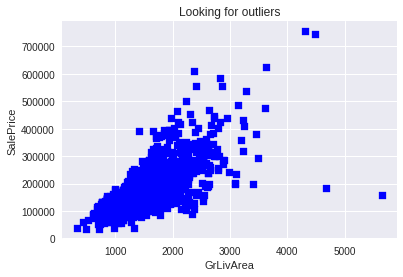

In [5]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf by the author of the dataset
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train = train[train.GrLivArea < 4000]

In [6]:
# Log transform the target for official scoring
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

In [7]:
# Handle missing values for features where median/mean/mode doesn't make sense

# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

In [8]:
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [9]:
# Encode some categorical features as ordered numbers when there is information in the order
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

Then we will create new features, in 3 ways : 

 1. Simplifications of existing features
 2. Combinations of existing features
 3. Polynomials on the top 10 existing features

In [10]:
# Create new features
# 1* Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [11]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000
OverallQual          0.819
AllSF                0.817
AllFlrsSF            0.729
GrLivArea            0.719
SimplOverallQual     0.708
ExterQual            0.681
GarageCars           0.680
TotalBath            0.673
KitchenQual          0.667
GarageScore          0.657
GarageArea           0.655
TotalBsmtSF          0.642
SimplExterQual       0.636
SimplGarageScore     0.631
BsmtQual             0.615
1stFlrSF             0.614
SimplKitchenQual     0.610
OverallGrade         0.604
SimplBsmtQual        0.594
FullBath             0.591
YearBuilt            0.589
ExterGrade           0.587
YearRemodAdd         0.569
FireplaceQu          0.547
GarageYrBlt          0.544
TotRmsAbvGrd         0.533
SimplOverallGrade    0.527
SimplKitchenScore    0.523
FireplaceScore       0.518
                     ...  
SimplBsmtCond        0.204
BedroomAbvGr         0.204
AllPorchSF           0.199
LotFrontage          0.174
SimplFu

In [12]:
# Create new features
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

In [13]:
# Differentiate numerical features (minus the target) and categorical features

categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 117
Categorical features : 26


In [14]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [15]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

86 skewed numerical features to log transform


In [16]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


**Modeling**

In [17]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 319
X_train : (1019, 319)
X_test : (437, 319)
y_train : (1019,)
y_test : (437,)


In [18]:
# Standardize numerical features
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

/usr/lib/python3/dist-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Standardization cannot be done before  the partitioning, as we don't want to fit the StandardScaler on some observations that will later be used in the test set.

In [19]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

RMSE on Training set : 12638706954.78128
RMSE on Test set : 151933201044.65393


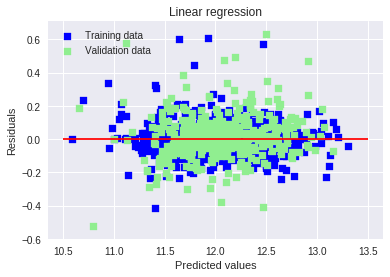

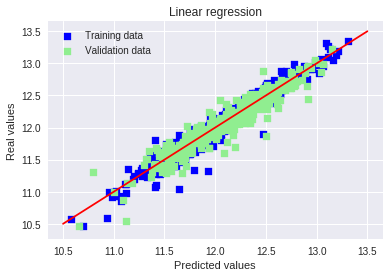

In [20]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

## Test data


In [21]:
# Get data
test = pd.read_csv("input/test.csv")
print("Test data : " + str(test.shape))

Test data : (1459, 80)


In [22]:
# Check for duplicates
idsUnique = len(set(test.Id))
idsTotal = test.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop Id column
test.drop("Id", axis = 1, inplace = True)

There are 0 duplicate IDs for 1459 total entries


In [23]:
# Handle missing values for features where median/mean/mode doesn't make sense

# Alley : data description says NA means "no alley access"
test.loc[:, "Alley"] = test.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
test.loc[:, "BedroomAbvGr"] = test.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
test.loc[:, "BsmtQual"] = test.loc[:, "BsmtQual"].fillna("No")
test.loc[:, "BsmtCond"] = test.loc[:, "BsmtCond"].fillna("No")
test.loc[:, "BsmtExposure"] = test.loc[:, "BsmtExposure"].fillna("No")
test.loc[:, "BsmtFinType1"] = test.loc[:, "BsmtFinType1"].fillna("No")
test.loc[:, "BsmtFinType2"] = test.loc[:, "BsmtFinType2"].fillna("No")
test.loc[:, "BsmtFullBath"] = test.loc[:, "BsmtFullBath"].fillna(0)
test.loc[:, "BsmtHalfBath"] = test.loc[:, "BsmtHalfBath"].fillna(0)
test.loc[:, "BsmtUnfSF"] = test.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
test.loc[:, "CentralAir"] = test.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
test.loc[:, "Condition1"] = test.loc[:, "Condition1"].fillna("Norm")
test.loc[:, "Condition2"] = test.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
test.loc[:, "EnclosedPorch"] = test.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
test.loc[:, "ExterCond"] = test.loc[:, "ExterCond"].fillna("TA")
test.loc[:, "ExterQual"] = test.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
test.loc[:, "Fence"] = test.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
test.loc[:, "FireplaceQu"] = test.loc[:, "FireplaceQu"].fillna("No")
test.loc[:, "Fireplaces"] = test.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
test.loc[:, "Functional"] = test.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
test.loc[:, "GarageType"] = test.loc[:, "GarageType"].fillna("No")
test.loc[:, "GarageFinish"] = test.loc[:, "GarageFinish"].fillna("No")
test.loc[:, "GarageQual"] = test.loc[:, "GarageQual"].fillna("No")
test.loc[:, "GarageCond"] = test.loc[:, "GarageCond"].fillna("No")
test.loc[:, "GarageArea"] = test.loc[:, "GarageArea"].fillna(0)
test.loc[:, "GarageCars"] = test.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
test.loc[:, "HalfBath"] = test.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
test.loc[:, "HeatingQC"] = test.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
test.loc[:, "KitchenAbvGr"] = test.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
test.loc[:, "KitchenQual"] = test.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
test.loc[:, "LotFrontage"] = test.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
test.loc[:, "LotShape"] = test.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
test.loc[:, "MasVnrType"] = test.loc[:, "MasVnrType"].fillna("None")
test.loc[:, "MasVnrArea"] = test.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
test.loc[:, "MiscFeature"] = test.loc[:, "MiscFeature"].fillna("No")
test.loc[:, "MiscVal"] = test.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
test.loc[:, "OpenPorchSF"] = test.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
test.loc[:, "PavedDrive"] = test.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
test.loc[:, "PoolQC"] = test.loc[:, "PoolQC"].fillna("No")
test.loc[:, "PoolArea"] = test.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
test.loc[:, "SaleCondition"] = test.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
test.loc[:, "ScreenPorch"] = test.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
test.loc[:, "TotRmsAbvGrd"] = test.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
test.loc[:, "Utilities"] = test.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
test.loc[:, "WoodDeckSF"] = test.loc[:, "WoodDeckSF"].fillna(0)

In [24]:
# Some numerical features are actually really categories
test = test.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

# Encode some categorical features as ordered numbers when there is information in the order
test = test.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )


# Create new features
# 1* Simplifications of existing features
test["SimplOverallQual"] = test.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
test["SimplOverallCond"] = test.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
test["SimplPoolQC"] = test.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
test["SimplGarageCond"] = test.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
test["SimplGarageQual"] = test.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
test["SimplFireplaceQu"] = test.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplFireplaceQu"] = test.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplFunctional"] = test.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
test["SimplKitchenQual"] = test.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
test["SimplHeatingQC"] = test.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
test["SimplBsmtFinType1"] = test.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
test["SimplBsmtFinType2"] = test.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
test["SimplBsmtCond"] = test.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
test["SimplBsmtQual"] = test.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
test["SimplExterCond"] = test.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
test["SimplExterQual"] = test.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
test["OverallGrade"] = test["OverallQual"] * test["OverallCond"]
# Overall quality of the garage
test["GarageGrade"] = test["GarageQual"] * test["GarageCond"]
# Overall quality of the exterior
test["ExterGrade"] = test["ExterQual"] * test["ExterCond"]
# Overall kitchen score
test["KitchenScore"] = test["KitchenAbvGr"] * test["KitchenQual"]
# Overall fireplace score
test["FireplaceScore"] = test["Fireplaces"] * test["FireplaceQu"]
# Overall garage score
test["GarageScore"] = test["GarageArea"] * test["GarageQual"]
# Overall pool score
test["PoolScore"] = test["PoolArea"] * test["PoolQC"]
# Simplified overall quality of the house
test["SimplOverallGrade"] = test["SimplOverallQual"] * test["SimplOverallCond"]
# Simplified overall quality of the exterior
test["SimplExterGrade"] = test["SimplExterQual"] * test["SimplExterCond"]
# Simplified overall pool score
test["SimplPoolScore"] = test["PoolArea"] * test["SimplPoolQC"]
# Simplified overall garage score
test["SimplGarageScore"] = test["GarageArea"] * test["SimplGarageQual"]
# Simplified overall fireplace score
test["SimplFireplaceScore"] = test["Fireplaces"] * test["SimplFireplaceQu"]
# Simplified overall kitchen score
test["SimplKitchenScore"] = test["KitchenAbvGr"] * test["SimplKitchenQual"]
# Total number of bathrooms
test["TotalBath"] = test["BsmtFullBath"] + (0.5 * test["BsmtHalfBath"]) + \
test["FullBath"] + (0.5 * test["HalfBath"])
# Total SF for house (incl. basement)
test["AllSF"] = test["GrLivArea"] + test["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
test["AllFlrsSF"] = test["1stFlrSF"] + test["2ndFlrSF"]
# Total SF for porch
test["AllPorchSF"] = test["OpenPorchSF"] + test["EnclosedPorch"] + \
test["3SsnPorch"] + test["ScreenPorch"]
# Has masonry veneer or not
test["HasMasVnr"] = test.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
test["BoughtOffPlan"] = test.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [25]:
# Create new features
# 3* Polynomials on the top 10 existing features
test["OverallQual-s2"] = test["OverallQual"] ** 2
test["OverallQual-s3"] = test["OverallQual"] ** 3
test["OverallQual-Sq"] = np.sqrt(test["OverallQual"])
test["AllSF-2"] = test["AllSF"] ** 2
test["AllSF-3"] = test["AllSF"] ** 3
test["AllSF-Sq"] = np.sqrt(test["AllSF"])
test["AllFlrsSF-2"] = test["AllFlrsSF"] ** 2
test["AllFlrsSF-3"] = test["AllFlrsSF"] ** 3
test["AllFlrsSF-Sq"] = np.sqrt(test["AllFlrsSF"])
test["GrLivArea-2"] = test["GrLivArea"] ** 2
test["GrLivArea-3"] = test["GrLivArea"] ** 3
test["GrLivArea-Sq"] = np.sqrt(test["GrLivArea"])
test["SimplOverallQual-s2"] = test["SimplOverallQual"] ** 2
test["SimplOverallQual-s3"] = test["SimplOverallQual"] ** 3
test["SimplOverallQual-Sq"] = np.sqrt(test["SimplOverallQual"])
test["ExterQual-2"] = test["ExterQual"] ** 2
test["ExterQual-3"] = test["ExterQual"] ** 3
test["ExterQual-Sq"] = np.sqrt(test["ExterQual"])
test["GarageCars-2"] = test["GarageCars"] ** 2
test["GarageCars-3"] = test["GarageCars"] ** 3
test["GarageCars-Sq"] = np.sqrt(test["GarageCars"])
test["TotalBath-2"] = test["TotalBath"] ** 2
test["TotalBath-3"] = test["TotalBath"] ** 3
test["TotalBath-Sq"] = np.sqrt(test["TotalBath"])
test["KitchenQual-2"] = test["KitchenQual"] ** 2
test["KitchenQual-3"] = test["KitchenQual"] ** 3
test["KitchenQual-Sq"] = np.sqrt(test["KitchenQual"])
test["GarageScore-2"] = test["GarageScore"] ** 2
test["GarageScore-3"] = test["GarageScore"] ** 3
test["GarageScore-Sq"] = np.sqrt(test["GarageScore"])

# Differentiate numerical features (minus the target) and categorical features

categorical_features = test.select_dtypes(include = ["object"]).columns
numerical_features = test.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
test_num = test[numerical_features]
test_cat = test[categorical_features]


# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in test : " + str(test_num.isnull().values.sum()))
test_num = test_num.fillna(test_num.median())
print("Remaining NAs for numerical features in test : " + str(test_num.isnull().values.sum()))


# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = test_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
test_num[skewed_features] = np.log1p(test_num[skewed_features])


# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in test : " + str(test_cat.isnull().values.sum()))
test_cat = pd.get_dummies(test_cat)
print("Remaining NAs for categorical features in test : " + str(test_cat.isnull().values.sum()))

# Join categorical and numerical features
test = pd.concat([test_num, test_cat], axis = 1)
print("New number of features : " + str(test.shape[1]))

Numerical features : 117
Categorical features : 26
NAs for numerical features in test : 85
Remaining NAs for numerical features in test : 0
86 skewed numerical features to log transform
NAs for categorical features in test : 7
Remaining NAs for categorical features in test : 0
New number of features : 306


In [30]:
# Standardize numerical features

stdSc = StandardScaler()
test.loc[:, numerical_features] = stdSc.fit_transform(test.loc[:, numerical_features])
test.loc[:, numerical_features] = stdSc.transform(test.loc[:, numerical_features])


In [32]:
test.shape

(1459, 306)

In [31]:
# Look at predictions on test data

test_results = lr.predict(test)

ValueError: shapes (1459,306) and (319,) not aligned: 306 (dim 1) != 319 (dim 0)

## Saving output to csv file

In [ ]:
house_indices=pd.DataFrame(X_test.index)

finaloutput=pd.DataFrame(y_test_pred, house_indices)
finaloutput=finaloutput.reset_index()


finaloutput.columns=['Id','SalePrice']

finaloutput.head()

In [ ]:
finaloutput.shape

In [ ]:
finaloutput.to_csv('output.csv',index=False)